![](http://i.postimg.cc/BbD7fnL5/Screenshot-2025-11-04-201307.png)

# 1.IMPORTS


In [1]:
# ===============================
# 1. IMPORTS
# ===============================
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Subtract
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

import re
import nltk
import spacy
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

2025-11-07 10:22:06.517564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762510926.696630      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762510926.745477      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Converting Text file to csv

In [2]:
# Read data from text
with open('/kaggle/input/mit-plagairism-detection-dataset/train_snli.txt') as file:
    data = file.readlines()
    
# prepare csv file
with open('data.csv', 'w', newline= '') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)
    
    writer.writeheader()
    for line in tqdm(data):
        parts = line.strip().split('\t')
        source_txt = parts[0]
        plagiarishm_txt = parts[1]
        label = int(parts[2])
        
        writer.writerow({
            'source_txt' : source_txt,
            'plagiarism_txt' : plagiarishm_txt,
            'label' : label
        })
print('CSV file created successfully...')

  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


# 2. LOAD DATA


In [3]:

# Replace with your dataset path
df = pd.read_csv("data.csv")
df.head()

,source_txt,plagiarism_txt,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [4]:
df.duplicated().sum()


454

In [6]:
df.drop_duplicates(inplace=True)


# 3. BASIC CLEANING FUNCTION


In [7]:

import re, string


def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #Replace newlines with spaces
    text = text.translate(str.maketrans("", "", string.punctuation)) #Remove punctuation
    return text


# Apply cleaning
df["source_clean"] = df["source_txt"].astype(str).apply(clean_text)
df["plag_clean"] = df["plagiarism_txt"].astype(str).apply(clean_text)

# 4. TOKENIZATION


In [8]:

source = df['source_clean'].tolist()
plag = df['plag_clean'].tolist()
labels = df['label'].values


tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(source + plag)


source_seq = tokenizer.texts_to_sequences(source)
plag_seq = tokenizer.texts_to_sequences(plag)


max_len = 50
source_pad = pad_sequences(source_seq, maxlen=max_len)
plag_pad = pad_sequences(plag_seq, maxlen=max_len)

# 5. SPLIT DATA


In [9]:

X_train_src, X_test_src, X_train_plag, X_test_plag, y_train, y_test = train_test_split(
source_pad, plag_pad, labels, test_size=0.2, random_state=42)

# 6. BUILD LSTM MODEL


In [12]:
#Saimese LSTM network

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
lstm_dim = 64

input_a = Input(shape=(max_len,))
input_b = Input(shape=(max_len,))

embedding = Embedding(vocab_size , embedding_dim , input_length = max_len)
lstm = LSTM(lstm_dim)

encoded_a = lstm(embedding(input_a))
encoded_b = lstm(embedding(input_b))

merged = Subtract()([encoded_a , encoded_b])
merged = Dense(64 , activation = "relu")(merged)
merged = Dropout(0.5)(merged)
out = Dense(1,activation="sigmoid")(merged)

model = Model(inputs=[input_a , input_b], outputs=out)
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 50, 128)   │  3,874,432 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ embedding_2[0][0… │
│                     │                   │            │ embedding_2[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 64)        │          0 │ lstm_2[0][0],     │
│ (Subtract)          │                   │            │ lstm_2[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ subtract_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,928,065 (14.98 MB)

 Trainable params: 3,928,065 (14.98 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)


# 7. TRAIN MODEL


In [14]:

history = model.fit(
    [X_train_src, X_train_plag],
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/10


I0000 00:00:1762512063.392112     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


7339/7339 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - accuracy: 0.7391 - loss: 0.5013 - val_accuracy: 0.8336 - val_loss: 0.3755
Epoch 2/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.8518 - loss: 0.3454 - val_accuracy: 0.8524 - val_loss: 0.3433
Epoch 3/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.8806 - loss: 0.2870 - val_accuracy: 0.8595 - val_loss: 0.3380
Epoch 4/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.9011 - loss: 0.2461 - val_accuracy: 0.8614 - val_loss: 0.3435
Epoch 5/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.9156 - loss: 0.2155 - val_accuracy: 0.8646 - val_loss: 0.3511


# 8. EVALUATION


In [15]:

pred = model.predict([X_test_src, X_test_plag])
pred_label = (pred > 0.5).astype(int)


print("Accuracy:", accuracy_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

2294/2294 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Accuracy: 0.8592881282023329
              precision    recall  f1-score   support

           0       0.88      0.83      0.86     36778
           1       0.84      0.89      0.86     36606

    accuracy                           0.86     73384
   macro avg       0.86      0.86      0.86     73384
weighted avg       0.86      0.86      0.86     73384



# 9. PLOT TRAINING CURVES


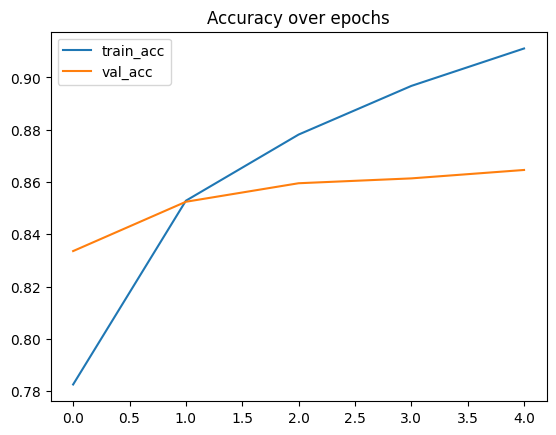

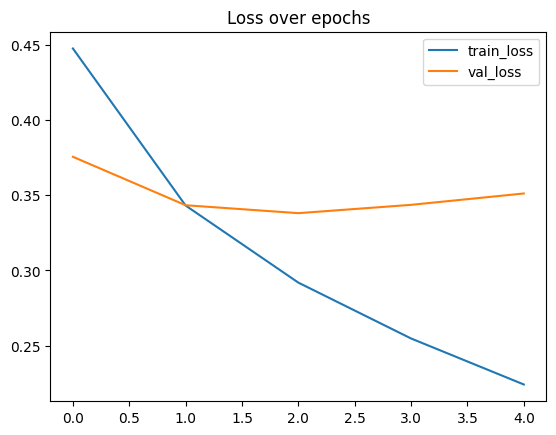

In [16]:

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

# 10. SAMPLE PREDICTION


In [17]:

idx = 0
src = X_test_src[idx:idx+1]
plg = X_test_plag[idx:idx+1]
print("Pred:", model.predict([src, plg])[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Pred: 0.7955357


# Testing Model on User Inputs

In [18]:
def predict_pair(source_text, plag_text, tokenizer, max_len):
    # Convert to sequences
    src_seq = tokenizer.texts_to_sequences([source_text])
    plg_seq = tokenizer.texts_to_sequences([plag_text])
    
    # Pad
    src_pad = pad_sequences(src_seq, maxlen=max_len)
    plg_pad = pad_sequences(plg_seq, maxlen=max_len)

    # Predict
    pred = model.predict([src_pad, plg_pad])[0][0]

    # Show result
    print("Prediction score:", pred)
    if pred > 0.5:
        print("✅ Likely PLAGIARIZED")
    else:
        print("❌ Likely NOT plagiarized")

    return pred


In [19]:
src = "A woman is standing outside wearing glasses."
plg = "A woman wearing glasses is outdoors."

predict_pair(src, plg, tokenizer, max_len)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction score: 0.9885006
✅ Likely PLAGIARIZED


0.9885006

In [20]:
src = "Two kids are sleeping on a bench."
plg = "A car is driving on the road."

predict_pair(src, plg, tokenizer, max_len)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction score: 0.045109056
❌ Likely NOT plagiarized


0.045109056

<span style="color: white; background-color: red; padding: 10px 20px; border-radius: 10px; font-size: 36px; font-weight: bold;">Smash That Upvote !! Thanks ! 🚀😃</span>
